In [1]:
import pandas as pd

def preprocessing(csv_file_path):
    data = pd.read_csv(csv_file_path)
    data.columns = ["EC_number", "Species", "smiles", "Compound_name", "Amino_encoding", "Kcat", "unit"]
    data = pd.DataFrame(data)
    return data

data = preprocessing("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\kcat_transferase.csv")
onehot_encoded_smiles = pd.read_csv("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\encoded_amino.csv")

In [2]:
from sklearn.decomposition import PCA


amino_pca = PCA(n_components=433) # 433 was the optimal number of components for 95% confidence.
principal_components = amino_pca.fit_transform(onehot_encoded_smiles)

# Convert to DataFrame for convenience
amino_pca_df = pd.DataFrame(data=principal_components)

In [3]:
import numpy as np

X = amino_pca_df
y = np.log10(data["Kcat"])


In [4]:
print(y)

0      -1.387216
1       0.008600
2      -1.080922
3      -1.425969
4      -0.420216
          ...   
4131    1.113943
4132    1.571709
4133    1.992554
4134    2.912063
4135    3.096910
Name: Kcat, Length: 4136, dtype: float64


In [5]:
amino_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,423,424,425,426,427,428,429,430,431,432
0,-6.260814,3.233607,-0.939699,-0.671007,-1.072594,-0.166186,0.093936,0.350908,0.706539,0.184849,...,0.480703,-0.536663,0.047966,0.238318,-0.217352,-1.229150,-0.444917,0.133830,-0.356298,-0.536651
1,-6.252592,3.232955,-0.952134,-0.687594,-1.056070,-0.151328,0.075121,0.344627,0.717727,0.185152,...,0.480680,-0.520282,0.069144,0.239957,-0.219337,-1.219913,-0.459986,0.148899,-0.334828,-0.537340
2,-6.247061,3.218509,-0.943114,-0.686935,-1.059343,-0.115982,0.097260,0.372542,0.735333,0.197906,...,0.484191,-0.481170,0.074250,0.248928,-0.286207,-1.258387,-0.464992,0.223261,-0.308734,-0.523618
3,-3.800123,-0.259436,0.613383,0.559863,0.904566,0.694478,-2.001746,1.991927,1.078039,0.257786,...,-0.316104,-0.366808,-0.997006,-0.329883,0.698332,0.488171,0.135597,-0.367099,-0.195289,0.075643
4,-4.529573,0.860604,0.132385,0.345013,0.960916,0.297965,-1.657127,1.547796,1.209693,0.185218,...,0.918170,-1.711390,-0.085016,0.450483,-0.601196,-0.788955,0.793306,0.836836,1.014473,0.252989


In [6]:
from sklearn.model_selection import train_test_split

# Assuming X is your amino encoding data and y is the kcat values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=2)  # 80% train, 20% temp

# Split the remaining 20% (X_temp, y_temp) into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2)  # 10% validation, 10% test


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# Define input dimension
input_dim = X_train.shape[1]

model_nn = Sequential()
model_nn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(input_dim,)))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(1))
# Compile the model
model_nn.compile(optimizer='adam', loss='mse')

# Train the model
model_nn.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/30
104/104 [==============================] - 2s 8ms/step - loss: 6.4263 - val_loss: 4.5121
Epoch 2/30
104/104 [==============================] - 0s 4ms/step - loss: 4.7276 - val_loss: 4.1301
Epoch 3/30
104/104 [==============================] - 0s 3ms/step - loss: 4.1407 - val_loss: 3.7573
Epoch 4/30
104/104 [==============================] - 0s 3ms/step - loss: 3.7368 - val_loss: 3.4544
Epoch 5/30
104/104 [==============================] - 0s 4ms/step - loss: 3.4206 - val_loss: 3.2362
Epoch 6/30
104/104 [==============================] - 1s 8ms/step - loss: 3.1083 - val_loss: 2.9593
Epoch 7/30
104/104 [==============================] - 1s 8ms/step - loss: 2.9020 - val_loss: 2.7681
Epoch 8/30
104/104 [==============================] - 0s 3ms/step - loss: 2.6571 - val_loss: 2.5915
Epoch 9/30
104/104 [==============================] - 0s 3ms/step - loss: 2.5289 - val_loss: 2.4543
Epoch 10/30
104/104 [==============================] - 0s 3ms/step - loss: 2.3680 - val_loss: 2.2752

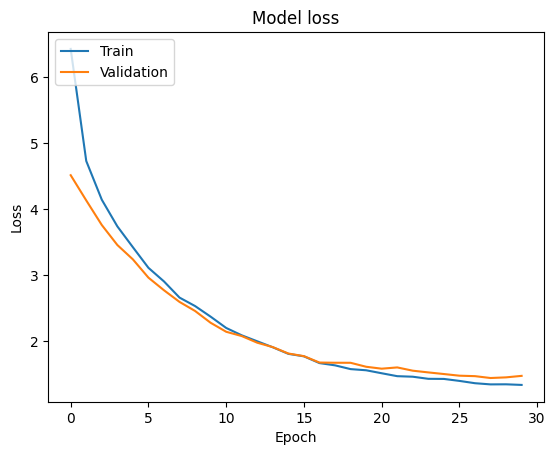

In [28]:
import matplotlib.pyplot as plt

plt.plot(model_nn.history['loss'])
plt.plot(model_nn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

model_gbm = lgb.train(params, lgb_train, num_boost_round=500, valid_sets=[lgb_val])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110406
[LightGBM] [Info] Number of data points in the train set: 3308, number of used features: 433
[LightGBM] [Info] Start training from score 0.199956


In [30]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Get predictions from both models on the test set
nn_preds_test = model_nn.predict(X_test)
gbm_preds_test = model_gbm.predict(X_test)

# Combine predictions to use as features for the meta-model
stacked_preds_test = np.column_stack((nn_preds_test, gbm_preds_test))

# Train the meta-model on the training set
meta_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
meta_model_xgb.fit(stacked_preds_test, y_test)

# Now, you can use the trained meta-model to make predictions on new data
y_val_pred = meta_model_xgb.predict(stacked_preds_test)

AttributeError: 'History' object has no attribute 'predict'

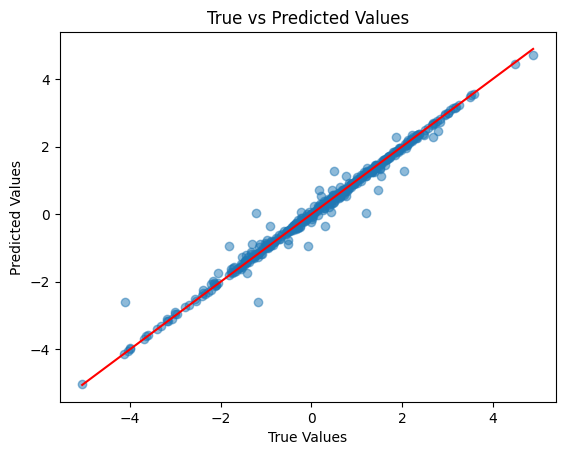

In [20]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_val_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line for perfect prediction
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_val_pred)
rmse = mean_squared_error(y_test, y_val_pred, squared=False)
mae = mean_absolute_error(y_test, y_val_pred)
r2 = r2_score(y_test, y_val_pred)
result = np.corrcoef(y_test, y_val_pred)[0,1]

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"Pearson Score: {result}")

MSE: 0.036605333561036596
RMSE: 0.1913252036743633
MAE: 0.08475832340901454
R2 Score: 0.985636890687652
Pearson Score: 0.9928649327967377


ValueError: x and y must be the same size

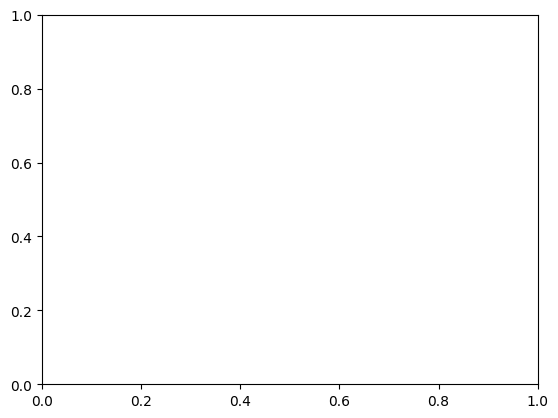

In [19]:
import matplotlib.pyplot as plt

plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')  # Line for perfect prediction
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [414, 828]

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
result = np.corrcoef(y_test, y_test_pred)[0,1]

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"Pearson Score: {result}")

MSE: 1.2107849265711648
RMSE: 1.1003567269622905
MAE: 0.8000336992580062
R2 Score: 0.5249152360519453
Pearson Score: 0.742560718937366
